Скачаем датасет с Kaggle (https://www.kaggle.com/c/journey-springfield/data)

In [1]:
!pip uninstall -y kaggle
!pip install --upgrade pip
!pip install kaggle==1.5.6

Found existing installation: kaggle 1.5.12
Uninstalling kaggle-1.5.12:
  Successfully uninstalled kaggle-1.5.12
     |████████████████████████████████| 1.7 MB 12.1 MB/s 
  Attempting uninstall: pip
    Found existing installation: pip 21.1.3
    Uninstalling pip-21.1.3:
      Successfully uninstalled pip-21.1.3
     |████████████████████████████████| 58 kB 4.6 MB/s             
  Preparing metadata (setup.py) ... done
  Created wheel for kaggle: filename=kaggle-1.5.6-py3-none-any.whl size=72858 sha256=10ad6b55935e81d9ef9bbf5a0b5cc110f341b5a5a8525e1fe399aa20012093f6
  Stored in directory: /root/.cache/pip/wheels/aa/e7/e7/eb3c3d514c33294d77ddd5a856bdd58dc9c1fabbed59a02a2b
Successfully built kaggle


In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"eugenepakhomove","key":"d86a4795888f165794cb8b5866b6078e"}'}

In [3]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 /content/kaggle.json
! kaggle competitions download -c journey-springfield
! unzip -q journey-springfield.zip

 96% 498M/521M [00:03<00:00, 168MB/s]
100% 521M/521M [00:03<00:00, 160MB/s]


In [4]:
import numpy as np
import pandas as pd
import PIL
from skimage import io
import pickle
from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path
import seaborn as sns
from skimage.io import imread

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch
from matplotlib import colors, pyplot as plt
from os.path import exists
from torchvision import models
from torchsummary import summary
%matplotlib inline
import warnings
import torch.nn.functional as F
import copy
from google.colab import drive
drive.mount('/content/drive')
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

Mounted at /content/drive


In [5]:
train_dir=Path('train')
test_dir=Path('testset')
train_files=sorted(list(train_dir.rglob('*.jpg')))
test_files=sorted(list(test_dir.rglob('*.jpg')))
print('Изображений в обучающей выборке:',len(train_files))
print('Изображений в тестовой выборке',len(test_files))

Изображений в обучающей выборке: 20933
Изображений в тестовой выборке 991


Разделим выборку на обучающую и валидационную части, получим label для каждого изображения. Метки классов представлены в виде названий папок, в которых лежат картинки


In [6]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
train_val_labels=[img.parent.name for img in train_files]
train_files,val_files=train_test_split(train_files,test_size=0.2,stratify=train_val_labels)

Отдельно получим имена персонажей из обучающей и валидационной выборки

In [7]:
train_labels=[img.parent.name for img in train_files]
val_labels=[img.parent.name for img in val_files]

Посмотрим распределение по классам

In [8]:
def count_distribution(labels):
    df=pd.DataFrame(labels,columns=['name'])
    df['count']=1
    return df.groupby('name').count().sort_values('count',ascending=False)

In [9]:
df=count_distribution(train_val_labels)
df

,count
name,
homer_simpson,2246
ned_flanders,1454
moe_szyslak,1452
lisa_simpson,1354
bart_simpson,1342
marge_simpson,1291
krusty_the_clown,1206
principal_skinner,1194
charles_montgomery_burns,1193


In [10]:
def show_distribution(data:pd.DataFrame,min_level=True,max_level=True):
    plt.figure(figsize=(15,9))
    sns.barplot(x=data.index,y=data['count'],orient='v').set_xticklabels(data.index,rotation=90)
    if max_level:
        plt.axhline(y=300)
    if min_level:
        plt.axhline(y=100, color='red')
    plt.show()

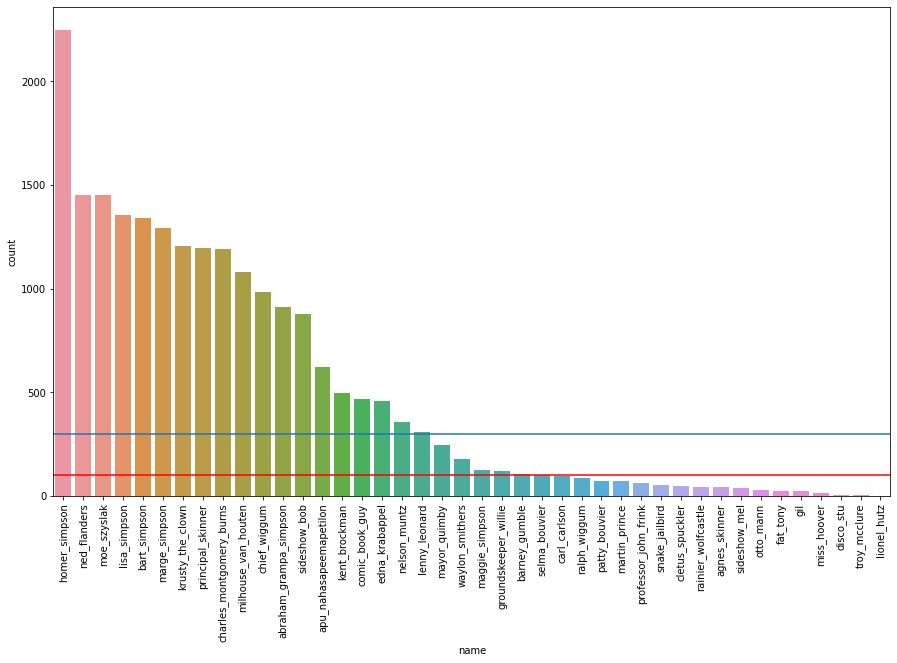

In [11]:
#Визуализируем распределение по классам в виде гистограммы
show_distribution(df)

Видно что датасет сильно несбалансирован.Дополним классы в которых меньше 300 изображений

In [12]:
def create_dct(train_files,train_labels):
    dct={}
    for label in np.unique(train_labels):
        dct[label]=[]
    for label_i,file_i in zip(train_labels,train_files):
        dct[label_i].append(file_i)
    for key in dct.keys():
        if len(dct[key])<300:
            dct[key]=dct[key]*(300//len(dct[key]))
            dct[key]=dct[key]+dct[key][:300-len(dct[key])]
    return dct

In [13]:
simpsons_dictionary=create_dct(train_files,train_labels)
for key in simpsons_dictionary.keys():
    print(f'{key}\t {len(simpsons_dictionary[key])}')

abraham_grampa_simpson	 730
agnes_skinner	 300
apu_nahasapeemapetilon	 498
barney_gumble	 300
bart_simpson	 1074
carl_carlson	 300
charles_montgomery_burns	 954
chief_wiggum	 789
cletus_spuckler	 300
comic_book_guy	 375
disco_stu	 300
edna_krabappel	 366
fat_tony	 300
gil	 300
groundskeeper_willie	 300
homer_simpson	 1797
kent_brockman	 398
krusty_the_clown	 965
lenny_leonard	 300
lionel_hutz	 300
lisa_simpson	 1083
maggie_simpson	 300
marge_simpson	 1033
martin_prince	 300
mayor_quimby	 300
milhouse_van_houten	 863
miss_hoover	 300
moe_szyslak	 1161
ned_flanders	 1163
nelson_muntz	 300
otto_mann	 300
patty_bouvier	 300
principal_skinner	 955
professor_john_frink	 300
rainier_wolfcastle	 300
ralph_wiggum	 300
selma_bouvier	 300
sideshow_bob	 702
sideshow_mel	 300
snake_jailbird	 300
troy_mcclure	 300
waylon_smithers	 300


In [14]:
train_files=[]
for key in simpsons_dictionary.keys():
    train_files.extend(simpsons_dictionary[key])
train_labels=[img.parent.name for img in train_files]

In [15]:
device='cuda:0' if torch.cuda.is_available() else 'cpu' # обучаем на gpu, если это возможно
data_modes=['train','val','test']
rescale_size=224 # все изображения будут масштабированны к заданному размеру
classes=len(np.unique(val_labels))# количество классов классификации

Ниже описан враппер для работы над датасетом. Каждое PIL изображение масштабируется к заданному размеру, к нему применяются аугментации, зависящие от принадлежности к выборке. ToTensor конвертирует изображения с параметрами [0,255] в FloatTensor с параметрами [0,1], затем производится скалирование: $input = \frac{input - \mu}{\text{standard deviation}} $,      константы - средние и дисперсии по каналам на основе ImageNet

In [16]:
train_transforms=transforms.Compose([
        transforms.Resize(size=(rescale_size,rescale_size)),
        transforms.RandomChoice([
            #transforms.RandomCrop(size=200),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(degrees=(-30,30)),
            transforms.RandomPerspective()
        ]),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
val_test_transforms=transforms.Compose([
        transforms.Resize(size=(rescale_size,rescale_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [17]:
class SimpsonDataset(Dataset):
    def __init__(self,files,mode):
        super().__init__()
        self.files=files
        self.mode=mode
        if self.mode not in data_modes:
            print(f'{self.mode} is not correct. Correct_modes: {data_modes}')
            raise NameError
        self.len=len(files)
        self.label_encoder=LabelEncoder()
        if self.mode!='test':
            self.labels=[img.parent.name for img in self.files]
            self.label_encoder.fit(self.labels)
            with open('label_encoder.pkl','wb') as le_dump_files:
                pickle.dump(self.label_encoder,le_dump_files)
    def __len__(self):
        return self.len
    def load_sample(self,image):
        image=Image.open(image)
        image.load()
        return image
    def __getitem__(self,index):
        x=self.load_sample(self.files[index])
        if self.mode=='test':
            x=val_test_transforms(x)
            return x
        else:
            label=self.labels[index]
            label_id=self.label_encoder.transform([label])
            y=label_id.item()
            if self.mode=='train':
                x=train_transforms(x)
                return x,y
            else:
                x=val_test_transforms(x)
                return x,y

In [18]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [19]:
train_dataset=SimpsonDataset(train_files,mode='train')
val_dataset=SimpsonDataset(val_files,mode='val')

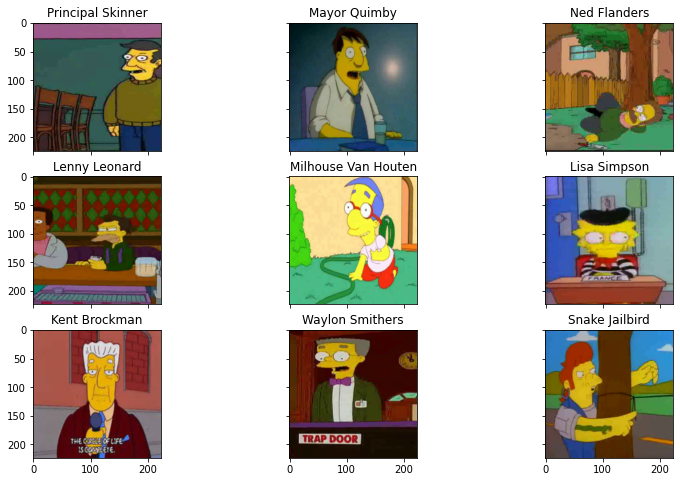

In [20]:
#Посмотрим на изображения из валидационной выборки
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(13, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

In [58]:
def fit_epoch(model,loss_fn,optimizer,train_loader):
    train_loss=0.0
    train_acc=0.0
    proc_data=0
    model.train()
    for input,label in tqdm_notebook(train_loader):
        input=input.to(device)
        label=label.to(device)
        optimizer.zero_grad()

        pred=model(input)
        loss=loss_fn(pred,label)
        loss.backward()
        optimizer.step()
        pred=torch.argmax(pred,dim=1)

        train_loss+=loss.item()*input.size(0)
        train_acc+=torch.sum(pred==label.data)
        proc_data+=input.size(0)

        input.to('cpu')
        label.to('cpu')
        pred.to('cpu')
        del input
        del label
        del pred
    torch.cuda.empty_cache()
    return train_loss/proc_data,train_acc.cpu().numpy()/proc_data

In [59]:
def eval_epoch(model,val_loader,loss_fn):
    model.eval()
    val_loss=0.0
    val_acc=0.0
    proc_data=0
    with torch.no_grad():
        for input,label in val_loader:
            input=input.to(device)
            label=label.to(device)

            pred=model(input)
            loss=loss_fn(pred,label)
            val_loss+=loss.item()*input.size(0)
            pred=torch.argmax(pred,dim=1)
            val_acc+=torch.sum(pred==label.data)
            proc_data+=input.size(0)
            input.to('cpu')
            label.to('cpu')
            pred.to('cpu')
            del input
            del label
            del pred
    torch.cuda.empty_cache()
    return val_loss/proc_data,val_acc.double()/proc_data

In [60]:
def train(model,loss_fn,optimizer,epochs,batch_size,train_dataset,val_dataset):
    train_loader=DataLoader(train_dataset,batch_size=batch_size,shuffle=True,num_workers=1,pin_memory=True)
    val_loader=DataLoader(val_dataset,batch_size=batch_size,shuffle=True,num_workers=1,pin_memory=True)
    scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau(optim,mode='min',factor=0.2,patience=5,verbose=True)
    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        
        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, loss_fn, optimizer, train_loader)
            print("loss", train_loss)

            val_loss, val_acc = eval_epoch(model, val_loader, loss_fn)
            history.append((train_loss, train_acc, val_loss, val_acc))
            scheduler.step(val_loss)
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            torch.save(model.state_dict(),'/content/drive/MyDrive/Simpsons/{resNet152}')
            
    return history

In [24]:
def show_plots(history):
  train_loss,train_acc,val_loss,val_acc=zip(*history)
  plt.figure(figsize=(15, 9))
  plt.subplot(1,2,1)
  plt.plot(train_loss, label="train_loss")
  plt.plot(val_loss, label="val_loss")
  plt.legend(loc='best')
  plt.xlabel("epochs")  
  plt.ylabel("loss")
  plt.grid(True)
  plt.subplot(1,2,2)
  plt.plot(train_acc,label='train accuracy')
  plt.plot(val_acc,label='val accuracy')
  plt.legend(loc='best')
  plt.xlabel('epochs')
  plt.ylabel('accuracy')
  plt.grid(True)
  plt.plot()
  plt.show()

In [25]:
class SimpleCnn(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1=nn.Sequential(
            nn.Conv2d(3,64,kernel_size=(7,7),stride=1,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64,128,kernel_size=(5,5),stride=1,padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2)
        )
        self.conv2=nn.Sequential(
            nn.Conv2d(128,128,kernel_size=(3,3),stride=1,padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128,128,kernel_size=(3,3),stride=1,padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2)
        )
        self.conv3=nn.Sequential(
            nn.Conv2d(128,256,kernel_size=(3,3),stride=1,padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256,256,kernel_size=(3,3),stride=1,padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2)
        )
        self.conv4=nn.Sequential(
            nn.Conv2d(256,256,kernel_size=(3,3),stride=1,padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256,256,kernel_size=(3,3),stride=1,padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2)
        )
        self.conv5=nn.Sequential(
            nn.Conv2d(256,512,kernel_size=(3,3),stride=1,padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512,512,kernel_size=(3,3),stride=1,padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2),
            nn.Flatten()
        )
        self.fc=nn.Sequential(
            nn.Linear(18432,512),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(512,classes) 
        )
    def forward(self,x):
        x=self.conv1(x)
        x=self.conv2(x)
        x=self.conv3(x)
        x=self.conv4(x)
        x=self.conv5(x)
        x=self.fc(x)
        return x
        

In [26]:
#model=SimpleCnn().to(device)
#optim=torch.optim.Adam(params=model.parameters())
#loss_fn=nn.CrossEntropyLoss()
#history=train(model,loss_fn,optim,5,32,train_dataset,val_dataset)

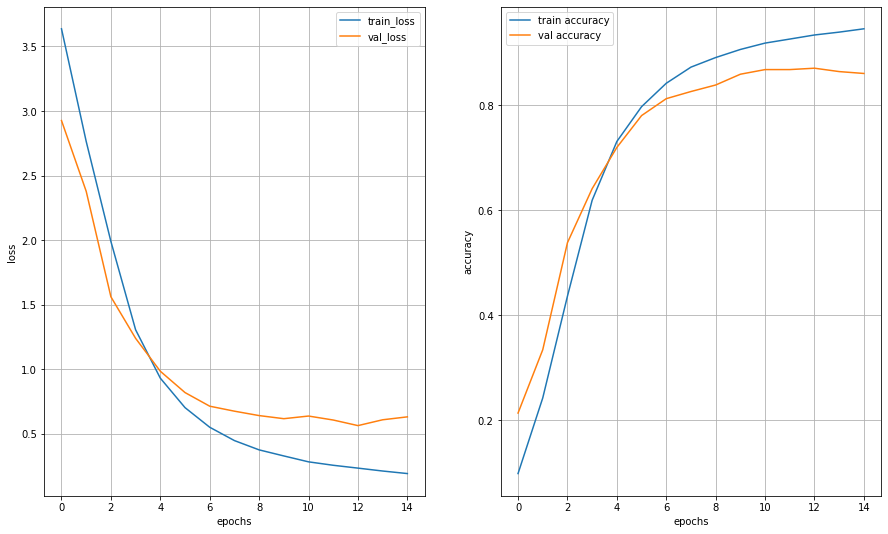

In [ ]:
#show_plots(history)

In [ ]:
myCnn=SimpleCnn().to(device)
myCnn.load_state_dict(torch.load('/content/drive/MyDrive/Simpsons/simpleCnn_15_epochs'))
myCnn.eval()

In [35]:
def predict(model, test_loader):
    with torch.no_grad():
        model.eval()
        logits = []
        for inputs in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs).cpu()
            logits.append(outputs)
            inputs.to("cpu")
            del inputs
        torch.cuda.empty_cache()
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [38]:
def get_submit(model,test_files):
  encoder=pickle.load(open('label_encoder.pkl','rb'))
  test_dataset=SimpsonDataset(test_files,mode='test')
  test_loader=DataLoader(test_dataset,shuffle=False,batch_size=16)
  probs=predict(model,test_loader)
  preds=encoder.inverse_transform(np.argmax(probs,axis=1))
  test_file_names=[path.name for path in test_files]
  submit=pd.DataFrame({'Id':test_file_names,'Expected':preds})
  return submit

In [33]:
def score_count(model,val_dataset):
  val_loader=DataLoader(val_dataset,shuffle=False,batch_size=16)
  label_encoder=pickle.load(open('label_encoder.pkl','rb'))
  logits=[]
  actual_labels=[]
  model.eval()
  with torch.no_grad():
    for input,label in val_loader:
      input=input.to(device)
      pred=model(input).cpu()
      logits.append(pred)
      actual_labels.extend(label)
      input.cpu()
      del input
    probs=np.argmax(nn.functional.softmax(torch.cat(logits),dim=-1).numpy(),axis=1)
    print('f1 macro:',f1_score(probs,actual_labels,average='macro'))
    print('f1 micro:',f1_score(probs,actual_labels,average='micro'))
    print('f1 weighted:',f1_score(probs,actual_labels,average='weighted'))

In [34]:
score_count(myCnn,val_dataset)

f1 macro: 0.9535252295838451
f1 micro: 0.9720563649390972
f1 weighted: 0.9719608097374923


Получим сабмит

In [40]:
my_cnn_submit=get_submit(myCnn,test_files)
my_cnn_submit.to_csv('/content/drive/MyDrive/Simpsons/my_cnn_15epochs.csv',index=False)
my_cnn_submit.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


# Residual Network

In [48]:
resnet152=models.resnet152(pretrained=True)
resnet152.fc=nn.Linear(2048,classes)
summary(resnet152.to(device),(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [52]:
optim=torch.optim.Adam(resnet152.parameters(),lr=0.0001)
loss_fn=nn.CrossEntropyLoss()
history=train(resnet152,loss_fn,optim,2,32,train_dataset,val_dataset)

epoch:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/701 [00:00<?, ?it/s]

loss 0.5175564185245105


epoch:  50%|█████     | 1/2 [19:40<19:40, 1180.32s/it]


Epoch 001 train_loss: 0.5176     val_loss 0.1348 train_acc 0.8818 val_acc 0.9690


  0%|          | 0/701 [00:00<?, ?it/s]

loss 0.3827251942403828


epoch: 100%|██████████| 2/2 [39:05<00:00, 1171.26s/it]


Epoch 002 train_loss: 0.3827     val_loss 0.1381 train_acc 0.9015 val_acc 0.9661


epoch: 100%|██████████| 2/2 [39:06<00:00, 1173.21s/it]


In [53]:
score_count(resnet152,val_dataset)

f1 macro: 0.9302356880111152
f1 micro: 0.9660855027465967
f1 weighted: 0.965603799748468


In [68]:
for param_group in optim.param_groups:
    print(param_group['lr'])

1e-05


Дообучим модель

In [61]:
train(resnet152,loss_fn,optim,3,16,train_dataset,val_dataset)

epoch:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/701 [00:00<?, ?it/s]

loss 0.07223650088844172


epoch:  33%|███▎      | 1/3 [19:40<39:21, 1180.83s/it]


Epoch 001 train_loss: 0.0722     val_loss 0.0781 train_acc 0.9838 val_acc 0.9830


  0%|          | 0/701 [00:00<?, ?it/s]

loss 0.06485135249556107


epoch:  67%|██████▋   | 2/3 [39:22<19:41, 1181.08s/it]


Epoch 002 train_loss: 0.0649     val_loss 0.0902 train_acc 0.9843 val_acc 0.9814


  0%|          | 0/701 [00:00<?, ?it/s]

loss 0.07402802004571896


epoch: 100%|██████████| 3/3 [59:03<00:00, 1181.22s/it]


Epoch 003 train_loss: 0.0740     val_loss 0.1039 train_acc 0.9813 val_acc 0.9752


epoch: 100%|██████████| 3/3 [59:04<00:00, 1181.56s/it]


[(0.07223650088844172,
  0.9837543515129876,
  0.07805651188174101,
  tensor(0.9830, device='cuda:0', dtype=torch.float64)),
 (0.06485135249556107,
  0.9843345532446666,
  0.09018133810590326,
  tensor(0.9814, device='cuda:0', dtype=torch.float64)),
 (0.07402802004571896,
  0.981299651878961,
  0.10394818439802983,
  tensor(0.9752, device='cuda:0', dtype=torch.float64))]

In [91]:
train(resnet152,loss_fn,optim,1,16,train_dataset,val_dataset)

epoch:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1401 [00:00<?, ?it/s]

loss 0.010931124499034495


epoch: 100%|██████████| 1/1 [21:58<00:00, 1318.64s/it]


Epoch 001 train_loss: 0.0109     val_loss 0.0628 train_acc 0.9974 val_acc 0.9885


epoch: 100%|██████████| 1/1 [21:59<00:00, 1319.83s/it]


[(0.010931124499034495,
  0.9974114076586629,
  0.06284811640087562,
  tensor(0.9885, device='cuda:0', dtype=torch.float64))]

In [92]:
score_count(resnet152,val_dataset)

f1 macro: 0.9596571316386838
f1 micro: 0.9885359445903988
f1 weighted: 0.9886562515544243


In [93]:
resnet152_submit=get_submit(resnet152,test_files)
resnet152_submit.to_csv('/content/drive/MyDrive/Simpsons/resnet152.csv',index=False)
resnet152_submit.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon
